<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Лемматизация</a></span></li><li><span><a href="#Проверка-на-дисбаланс-классов." data-toc-modified-id="Проверка-на-дисбаланс-классов.-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Проверка на дисбаланс классов.</a></span></li><li><span><a href="#Деление-на-выборки." data-toc-modified-id="Деление-на-выборки.-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Деление на выборки.</a></span></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>TF-IDF</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-Регрессия" data-toc-modified-id="Логистическая-Регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая Регрессия</a></span></li><li><span><a href="#Descision-Tree-Classifier" data-toc-modified-id="Descision-Tree-Classifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Descision Tree Classifier</a></span></li><li><span><a href="#LGBM-Classifier" data-toc-modified-id="LGBM-Classifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LGBM Classifier</a></span></li><li><span><a href="#CatBoost-Classifier" data-toc-modified-id="CatBoost-Classifier-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>CatBoost Classifier</a></span></li><li><span><a href="#Проверим-лучшую-модель-на-тестовой-выборке" data-toc-modified-id="Проверим-лучшую-модель-на-тестовой-выборке-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Проверим лучшую модель на тестовой выборке</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

%pip install transformers

%pip install catboost

%pip install seaborn

%pip install tqdm

%pip install pymystem3

Импортируем необходимые библиотеки

In [1]:
import re

import nltk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from tqdm import notebook, tqdm


In [2]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Manioka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Manioka\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Manioka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Manioka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Manioka\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Определим константы

In [3]:
STOP_WORDS = set(stopwords.words('english'))
RS = 12345

Посмотрим на твиты, которые Практикум заботливо подобрал для этого проекта.

In [4]:
# открываем файл
try:
    twits = pd.read_csv('G:\DataS\projects/toxic_comments.csv')
except:
    twits = pd.read_csv('/datasets/toxic_comments.csv')

In [5]:
twits.head(20)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [6]:
twits.tail(20)

,Unnamed: 0,text,toxic
159272,159431,While about half the references are from BYU-I...,0
159273,159432,Prague Spring \n\nI think that Prague Spring d...,0
159274,159433,I see this as having been merged; undoing one ...,0
159275,159434,and i'm going to keep posting the stuff u dele...,1
159276,159435,"""\n\nHow come when you download that MP3 it's ...",0
159277,159436,"I'll be on IRC, too, if you have a more specif...",0
159278,159437,It is my opinion that that happens to be off-t...,0
159279,159438,Please stop removing content from Wikipedia; i...,0
159280,159439,Image:Barack-obama-mother.jpg listed for delet...,0
159281,159440,"""Editing of article without Consensus & Remova...",0


In [7]:
# выведем размеры датафрейма 
print(twits.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
None


Заметила, что столбец Unnamed: 0 совпадает с индексом, но при проверке конца, это наблюдение не подтвердилось. Пока оставлю как есть.

In [8]:
# Проверка на наличие пропусков в данных
twits.isnull().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

Пропусков нет. Тогда до сих пор для меня загадка почему идет смещение и не совпадение с индексом, про которое писала ранее.

### Лемматизация

Создадим корпус постов. Преобразуем столбец 'text' в список текстов:

In [9]:
lemmatizer = WordNetLemmatizer()

Функция для создания токенов. Навешивает на каждое слово "ярлык" по частям речи.

In [10]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    
    return tag_dict.get(tag, wordnet.NOUN)

In [11]:
test = "Don't worry, be happy"
print([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(test)])

['Do', "n't", 'worry', ',', 'be', 'happy']


In [12]:
def lemmatize_twit(text):
    """Принимает на вход текст одного твита, 
    возвращает лемматизированный текст."""
    lemmatized_list = []
    
    for word in word_tokenize(text):
        lemmatized_list.append(lemmatizer.lemmatize(word, get_wordnet_pos(word)))
   
    return " ".join(lemmatized_list)


In [13]:
print(lemmatize_twit(test))

Do n't worry , be happy


In [14]:
def clear_text(text):
    """Принимает на вход текст твита, возвращает
    текст, очищенный от лишних символов."""
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    despacing = text.split()
    clear_text = " ".join(despacing)
    
    return clear_text

In [15]:
def lemmatize_all(column):
    """Принимает на вход столбец датафрейма с необработанными
    твитами, лемматизирует и очищает твиты от лишних символов, собирает 
    в новый столбец."""
    
    corpus = column # tweets['text']
    
    lemm_list = [0] * len(corpus) 
    for i in tqdm(range(len(corpus))):
        lemm_list[i] = lemmatize_twit(clear_text(corpus[i]))
        
    return lemm_list
    

In [16]:
lemm_list = lemmatize_all(twits['text'])

In [17]:
twits['lemm_text'] = lemm_list

In [18]:
twits.head(5)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Я не знаю, как делать подгрузку файла с лемматизированными твиттами, поэтому сохраню датасет с лемматизированными твитами в отдельный файлик, чтобы не ждать ещё раз 2 часа при перезапуске тетрадки.

но я решила закомментировать эти ячейки, чтобы на локальном компьютере все загрузилось.

In [19]:
#twits.to_csv(r'C:\Users\Manioka\Documents\lemmatized_twits.csv')

In [20]:
# twits = pd.read_csv(r'C:\Users\Manioka\Documents\lemmatized_twits.csv')
# twits.head(5)

,Unnamed: 0.1,Unnamed: 0,text,toxic,lemm_text
0,0,0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits make under my userna...
1,1,1,D'aww! He matches this background colour I'm s...,0,D aww He match this background colour I m seem...
2,2,2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not try to edit war It s ju...
3,3,3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestion on impro...
4,4,4,"You, sir, are my hero. Any chance you remember...",0,You sir be my hero Any chance you remember wha...


У меня не получилось лемматизировать тем методом, который рекомендуется в практикуме (там было время ожидания 70 часов) и мой старичок - ноут этого может не выдержать, поэтому я нашла более упрощенный вариант, который и использовала.

Полученный столбец я вставила в исходный датасет для дальнейшей обработки.

### Проверка на дисбаланс классов.

0    0.898388
1    0.101612
Name: toxic, dtype: float64


Text(0.5, 1.0, ' Доля классов')

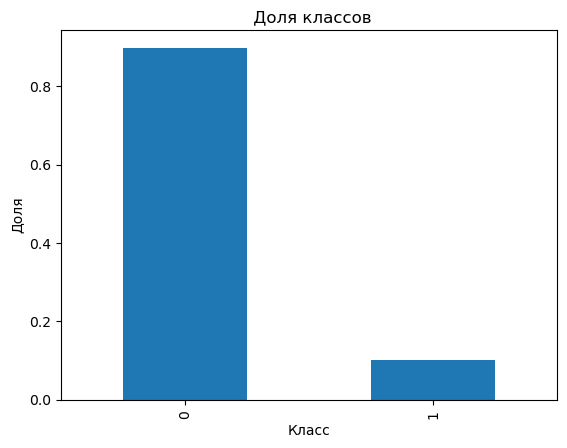

In [21]:
class_frequency  = twits['toxic'].value_counts(normalize = True)
print(class_frequency)
class_frequency.plot(kind = 'bar')
plt.xlabel('Класс')
plt.ylabel('Доля')
plt.title(' Доля классов')

Дисбаланс на лицо. А F1 мера очень "чувствительна" к дисбалансу. 

В теории Практикума рассказывали про методы борьбы с дисбалансом: преумножить недостающий класс или сократить превалирующий класс.

Осталось только выяснить каким образом.

In [22]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=RS)
    
    return features_upsampled, target_upsampled

### Деление на выборки.

In [23]:
features = twits.drop(['toxic'], axis=1)
target = twits['toxic']

Вроде Бы как практикуме или где-то я читала про то, что если так много данных, то выборки лучше делить в другой пропорции (90% на обучение и 10% на тестовую), поэтому делим признаки и целевой признак target исходного датасета на две части в соотношении 9:1. Получим тренировочную выборку и ответы.

In [24]:
features_train, features_other, target_train, target_other = train_test_split(
    features,
    target,
    test_size=0.4,
    random_state=RS,
    stratify=target
)

In [25]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_other,
    target_other,
    test_size=0.5,
    random_state=RS,
    stratify=target_other
)

In [26]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 5)

Спасибо практикуму за готовый код в теории. Я долго игралась с цифрами для repeat: увеличивая количество 1 в toxic. 

Создадим корпусы лемматизированных твитов на на тренировочной, 
тестовой и валидационной выборках

In [27]:
corpus_train = features_upsampled['lemm_text']
corpus_valid = features_valid['lemm_text']
corpus_test = features_test['lemm_text']

### TF-IDF

Создадим матрицы cо значениями TF-IDF по корпусу лемматизированных твитов на тренировочной, 
тестовой и валидационной выборках

In [28]:
count_tf_idf = TfidfVectorizer(stop_words=STOP_WORDS) 
tf_idf_train = count_tf_idf.fit_transform(corpus_train.apply(lambda x: np.str_(x)))

print("Размер тренировочной матрицы TF-IDF:", tf_idf_train.shape)

Размер тренировочной матрицы TF-IDF: (134423, 118108)


In [29]:
tf_idf_valid = count_tf_idf.transform(corpus_valid.apply(lambda x: np.str_(x)))

print("Размер тестовой матрицы TF-IDF:", tf_idf_valid.shape)

Размер тестовой матрицы TF-IDF: (31858, 118108)


In [30]:
tf_idf_test = count_tf_idf.transform(corpus_test.apply(lambda x: np.str_(x)))

print("Размер тестовой матрицы TF-IDF:", tf_idf_test.shape)

Размер тестовой матрицы TF-IDF: (31859, 118108)


## Обучение

### Логистическая Регрессия

In [31]:
logistic_regression = LogisticRegression(
    random_state=RS,
    C=6,
    penalty='l1',
    solver='liblinear',
    class_weight='balanced',
    max_iter = 10
)

In [32]:
logistic_regression.fit(tf_idf_train, target_upsampled)
predictions_log_reg = logistic_regression.predict(tf_idf_valid)

C:\Users\Manioka\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [33]:
print(f'F1 мера = {f1_score(target_valid, predictions_log_reg)}')

F1 мера = 0.7543344108139877


Ура! Первая же модель проходит по заявленному в заданию уровню метрики качества модели.

### Descision Tree Classifier

In [34]:
tree = DecisionTreeClassifier(random_state=RS)

In [35]:
tree.fit(tf_idf_train, target_upsampled)

DecisionTreeClassifier(random_state=12345)

In [36]:
predictions_tree = tree.predict(tf_idf_valid)

In [37]:
print(f'F1 мера = {f1_score(target_valid, predictions_tree)}')

F1 мера = 0.6658956194882173


Модель Descision Tree Classifier имеет самое низкое значение F1 меры среди трех моделей.

### LGBM Classifier

In [38]:
lgb = LGBMClassifier(random_state=RS)

In [39]:
lgb.fit(tf_idf_train, target_upsampled)

LGBMClassifier(random_state=12345)

In [40]:
predictions_lgb = lgb.predict(tf_idf_valid)

In [41]:
print(f'F1 мера = {f1_score(target_valid, predictions_lgb)}')

F1 мера = 0.7594420937157186


 LGBM Classifier получил меньшее значение выборки чем логистическая регрессия, но больше чем Descision Tree Classifier.

### CatBoost Classifier

In [42]:
cat = CatBoostClassifier(
    random_state=RS,
    loss_function="Logloss",
    iterations=100
)

In [43]:
cat.fit(tf_idf_train, target_upsampled)

Learning rate set to 0.5
0:	learn: 0.5247203	total: 3.98s	remaining: 6m 34s
1:	learn: 0.4748825	total: 8.27s	remaining: 6m 45s
2:	learn: 0.4476739	total: 10.4s	remaining: 5m 37s
3:	learn: 0.4290509	total: 12.4s	remaining: 4m 58s
4:	learn: 0.4134934	total: 14.3s	remaining: 4m 31s
5:	learn: 0.4002261	total: 16.2s	remaining: 4m 14s
6:	learn: 0.3894642	total: 18s	remaining: 3m 59s
7:	learn: 0.3799635	total: 19.8s	remaining: 3m 47s
8:	learn: 0.3699794	total: 21.5s	remaining: 3m 37s
9:	learn: 0.3636183	total: 23.3s	remaining: 3m 29s
10:	learn: 0.3562374	total: 25s	remaining: 3m 22s
11:	learn: 0.3500710	total: 26.7s	remaining: 3m 15s
12:	learn: 0.3442067	total: 28.4s	remaining: 3m 10s
13:	learn: 0.3395305	total: 30.2s	remaining: 3m 5s
14:	learn: 0.3356870	total: 31.9s	remaining: 3m
15:	learn: 0.3316959	total: 33.7s	remaining: 2m 56s
16:	learn: 0.3282744	total: 35.4s	remaining: 2m 53s
17:	learn: 0.3249796	total: 37.4s	remaining: 2m 50s
18:	learn: 0.3214459	total: 39.2s	remaining: 2m 47s
19:	le

In [44]:
cat_pred = cat.predict(tf_idf_valid)

In [45]:
print(f'F1 мера = {f1_score(target_valid, cat_pred)}')

F1 мера = 0.7570881226053641


### Проверим лучшую модель на тестовой выборке

In [49]:
predictions_lgb_reg = lgb.predict(tf_idf_test)

In [51]:
print(f'F1 мера LGBMClassifier на тестовой выборке= {f1_score(target_test, predictions_lgb_reg)}')

F1 мера = 0.7528409090909092


Я еще на всякий случай catboostу скормила тесты. Метрику проходит.

In [53]:
cat_pred_test = cat.predict(tf_idf_test)
print(f'F1 мера CatBoost на тестовой выборке = {f1_score(target_test, cat_pred_test)}')

F1 мера CatBoost на тестовой выборке = 0.7521919704660821


## Выводы

~Основное, что я поняла - это то, что у меня ооочень старый и слабый ноутбук~

**В ходе данного проекта было выполнено следующее:**

⎔ Проверены данные, в которых не было выяслено пропусков;

⎔ Проведена лемматизация текстов (очень долгая и сложная процедура);

**⎔ Найден дисбаланс классов в целевом признаке;**

**⎔ Проведена корректировка дисбаланса классов;**

⎔ Созданы корпусы лемматизированных твитов;

⎔ Данные поделены на выборки и уже полученные на полученных выборках были созданы матрицы cо значениями TF-IDF;

⎔ После подготовки данных были выбраны **четыре** модели :

а)Logistic Regression;

б)Descision Tree Classifier;

в)LGBM Classifier,

**г)CatBoostClassifier**

⎔ Мною были предприняты попытки использовать подбор гиперпараметров, но, увы, кроме ошибки и просьбы добавить в комьютер оперативной памяти я ничего не добилась гридом. Поэтому без подбора гиперпараметров обучены были модели.

⎔ Лучшее значение F1 - метрики получилось у **LGBMClassifier** и F1 = 0.75284, что удовлетворяет условиям задания.